In [1]:
%matplotlib widget
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from filterbank.components import Resonator,TransmissionLine,DirectionalFilter,ReflectorFilter,ManifoldFilter,Filterbank,BaseFilter
from filterbank.transformations import *
from filterbank.transformations import abcd_shuntload, chain,unchain,abcd2s
from filterbank.analysis import *


# mpl.rcParams.update(mpl.rcParamsDefault)

plt.style.use('~/Repos/louis-style-docs/default.mplstyle')

# mpl.rcParams['font.family'] = 'Avenir'

# # Font sizes for plot
# mpl.rcParams['font.size'] = 28
# mpl.rcParams['axes.titlesize'] = 24
# mpl.rcParams['axes.titlepad'] = 20
# mpl.rcParams['axes.labelsize'] = 18
# mpl.rcParams['xtick.labelsize'] = 14
# mpl.rcParams['ytick.labelsize'] = 14
# mpl.rcParams['legend.fontsize'] = 12
# mpl.rcParams['figure.titlesize'] = 24

# mpl.rcParams['xtick.top'] = True
# mpl.rcParams['xtick.minor.visible'] = True
# mpl.rcParams['ytick.right'] = True
# mpl.rcParams['ytick.minor.visible'] = True
# mpl.rcParams['xtick.minor.size'] = 3
# mpl.rcParams['xtick.major.size'] = 5
# mpl.rcParams['xtick.direction'] = 'out'
# mpl.rcParams['xtick.minor.width'] = 1
# mpl.rcParams['xtick.major.width'] = 1
# mpl.rcParams['ytick.minor.size'] = 3
# mpl.rcParams['ytick.major.size'] = 5
# mpl.rcParams['ytick.direction'] = 'out'
# mpl.rcParams['ytick.minor.width'] = 1
# mpl.rcParams['ytick.major.width'] = 1

# mpl.rcParams['axes.linewidth'] = 1
# mpl.rcParams['lines.linewidth'] = 0.5
# mpl.rcParams['lines.markersize'] = 0.5
# mpl.rcParams['figure.figsize'] = [2.5,2.5]
# mpl.rcParams['figure.dpi'] = 200
# mpl.rcParams["savefig.dpi"] = 400

# %matplotlib inline

fig_path = "~/Repos/filterbank-performance/figures/"

Filtertype_color_dict = {
    'ManifoldFilter' : np.array([86,199,74])/255,
    'ReflectorFilter' : np.array([242,131,45])/255,
    'DirectionalFilter' : np.array([90,136,237])/255
}

c = 3e8

In [2]:
nF = int(2e4)
f = np.linspace(200e9,460e9,nF)

nF = int(2e3)
f2 = np.linspace(345e9,355e9,nF)

f0_min = 220e9
f0_max = 440e9


R_spacings =[500,]
R_filter_widths = [500,]
n_R_spacings = len(R_spacings)
n_R_filter_widths = len(R_filter_widths)


## Variances
sigma_Ql = 0 #0.20
sigma_f0 = 0 #0.085


Z0_res = 80.6
eps_eff_res = 30.9
Qi_res = np.inf #1800


Z0_thru = 86.5
eps_eff_thru = 29.5

TL_thru = TransmissionLine(Z0_thru,eps_eff_thru)

TL_res = TransmissionLine(Z0_res,eps_eff_res,Qi=Qi_res)

TransmissionLinesDict = {
    'through' : TL_thru,
    'resonator' : TL_res,
    'MKID' : TL_thru
}

Filters = (ManifoldFilter, DirectionalFilter)

In [3]:
R_sweep_data = dict()

for Filter in Filters:
    Filterbank_data = dict()
    for R_spacing in R_spacings:
        for R_filter_width in R_filter_widths:
            

            FB = Filterbank(
                FilterClass=Filter,
                TransmissionLines=TransmissionLinesDict,
                f0_min=f0_min,
                f0_max=f0_max,
                Ql=175,
                oversampling=R_spacing/R_filter_width,
                sigma_f0=sigma_f0 * (R_filter_width / 300),
                sigma_Qc=sigma_Ql,
                compensate=False
            )


            # Caculate S-Parameters and realized values (suppress output)
            FB.S(f);
            FB.realized_parameters();

            Filterbank_data[(R_spacing,R_filter_width)] = FB
    
    R_sweep_data[Filter] = Filterbank_data

            

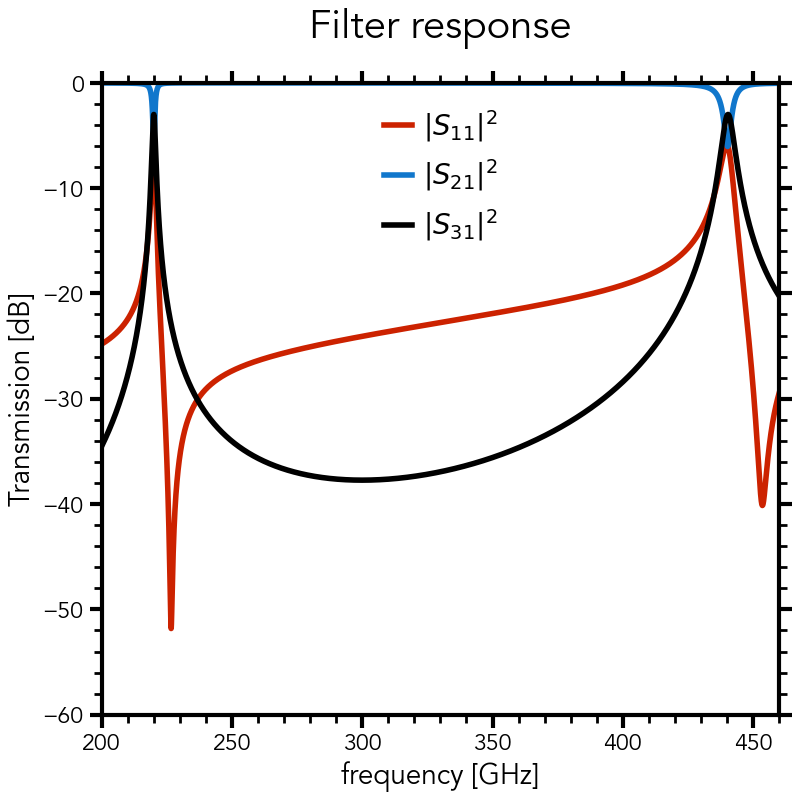

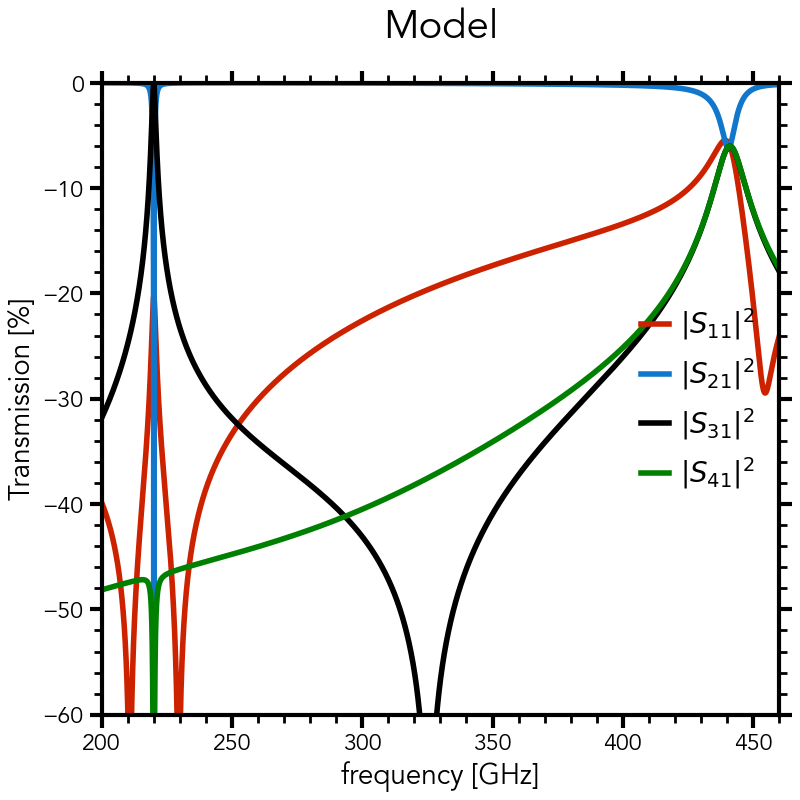

In [6]:
fig, ax =plt.subplots(nrows=1,ncols=1,figsize=(4,4),layout='constrained')
plt.rcParams['lines.linewidth'] = 2

FB : Filterbank = R_sweep_data[ManifoldFilter][(500,500)]

ith_filter = np.argmin(np.abs(FB.f0_realized-220e9))

filt : BaseFilter = FB.Filters[ith_filter]

filt.S(f)
filt.realized_parameters()

f0 = filt.f0_realized

S11_absSq = 10*np.log10(filt.S11_absSq)
S21_absSq = 10*np.log10(filt.S21_absSq)
S31_absSq = 10*np.log10(filt.S31_absSq)


ax.plot(f/1e9,S11_absSq,label=r'$|S_{11}|^2$',color='#C20')
ax.plot(f/1e9,S21_absSq,label=r'$|S_{21}|^2$',color='#17C')
ax.plot(f/1e9,S31_absSq,label=r'$|S_{31}|^2$',color=(0.,0.,0.))



ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('Transmission [dB]')  # Add a y-label to the axes.

# plt.yscale("log")
# plt.ylim(0.01,1)
plt.ylim(-60,0)
plt.xlim(200,460)

## Transparent background but not in axis
# fig.patch.set_facecolor('none')

ax.set_title("Filter response")  # Add a title to the axes.
ax.legend(loc="upper center",frameon=False);  # Add a legend.
savestr = fig_path + f"Response_manifold_filter.png"
# plt.savefig(fname=savestr)
fig.canvas.manager.set_window_title(savestr)

plt.show()

fig, ax =plt.subplots(nrows=1,ncols=1,figsize=(4,4),layout='constrained')
plt.rcParams['lines.linewidth'] = 2
artist = dict()

for Filter in Filters:
    alph = 1
    if Filter == ManifoldFilter:
        alph = 0.33

    FB : Filterbank = R_sweep_data[Filter][(500,500)]

    ith_filter = np.argmin(np.abs(FB.f0_realized-220e9))

    filt : BaseFilter = FB.Filters[ith_filter]

    filt.S(f)
    filt.realized_parameters()

    f0 = filt.f0_realized

    S11_absSq = 10*np.log10(filt.S11_absSq)
    S21_absSq = 10*np.log10(filt.S21_absSq)
    S31_absSq = 10*np.log10(filt.S31_absSq)
    if Filter == DirectionalFilter:
        S41_absSq = 10*np.log10(filt.S41_absSq)


    if Filter == DirectionalFilter:
        artist[(Filter,"S11")] = ax.plot(f/1e9,S11_absSq,label=r'$|S_{11}|^2$',color='#C20',alpha=alph)
        artist[(Filter,"S21")] = ax.plot(f/1e9,S21_absSq,label=r'$|S_{21}|^2$',color='#17C',alpha=alph)
        artist[(Filter,"S31")] = ax.plot(f/1e9,S31_absSq,label=r'$|S_{31}|^2$',color=(0.,0.,0.),alpha=alph)
        artist[(Filter,"S41")] = ax.plot(f/1e9,S41_absSq,label=r'$|S_{41}|^2$',color='g',alpha=alph)

    # if S41_absSq is not None:
    #     ax.plot(f2/1e9,S41_absSq * 100,label=r'$|S_{41}|^2$',color=(0.5,0.5,0.5),alpha=alph)

    ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
    ax.set_ylabel('Transmission [dB]')  # Add a y-label to the axes.
    
    # plt.yscale("log")
    # plt.ylim(0.01,1)
    plt.ylim(-60,0)
    plt.xlim(200,460)


legend_items = [(DirectionalFilter,"S11"),(DirectionalFilter,"S21"),(DirectionalFilter,"S31"),(DirectionalFilter,"S41")]



ax.set_title("Model")  # Add a title to the axes.
ax.legend(handles=list(np.squeeze(list(map(artist.get, legend_items) ))),loc="right",frameon=False);  # Add a legend.
savestr = fig_path + f"Response_directional_filter.png"

## Transparent background but not in axis
fig.patch.set_facecolor('none')

# plt.savefig(fname=savestr,facecolor=fig.get_facecolor(),edgecolor='none')
fig.canvas.manager.set_window_title(savestr)

plt.show()

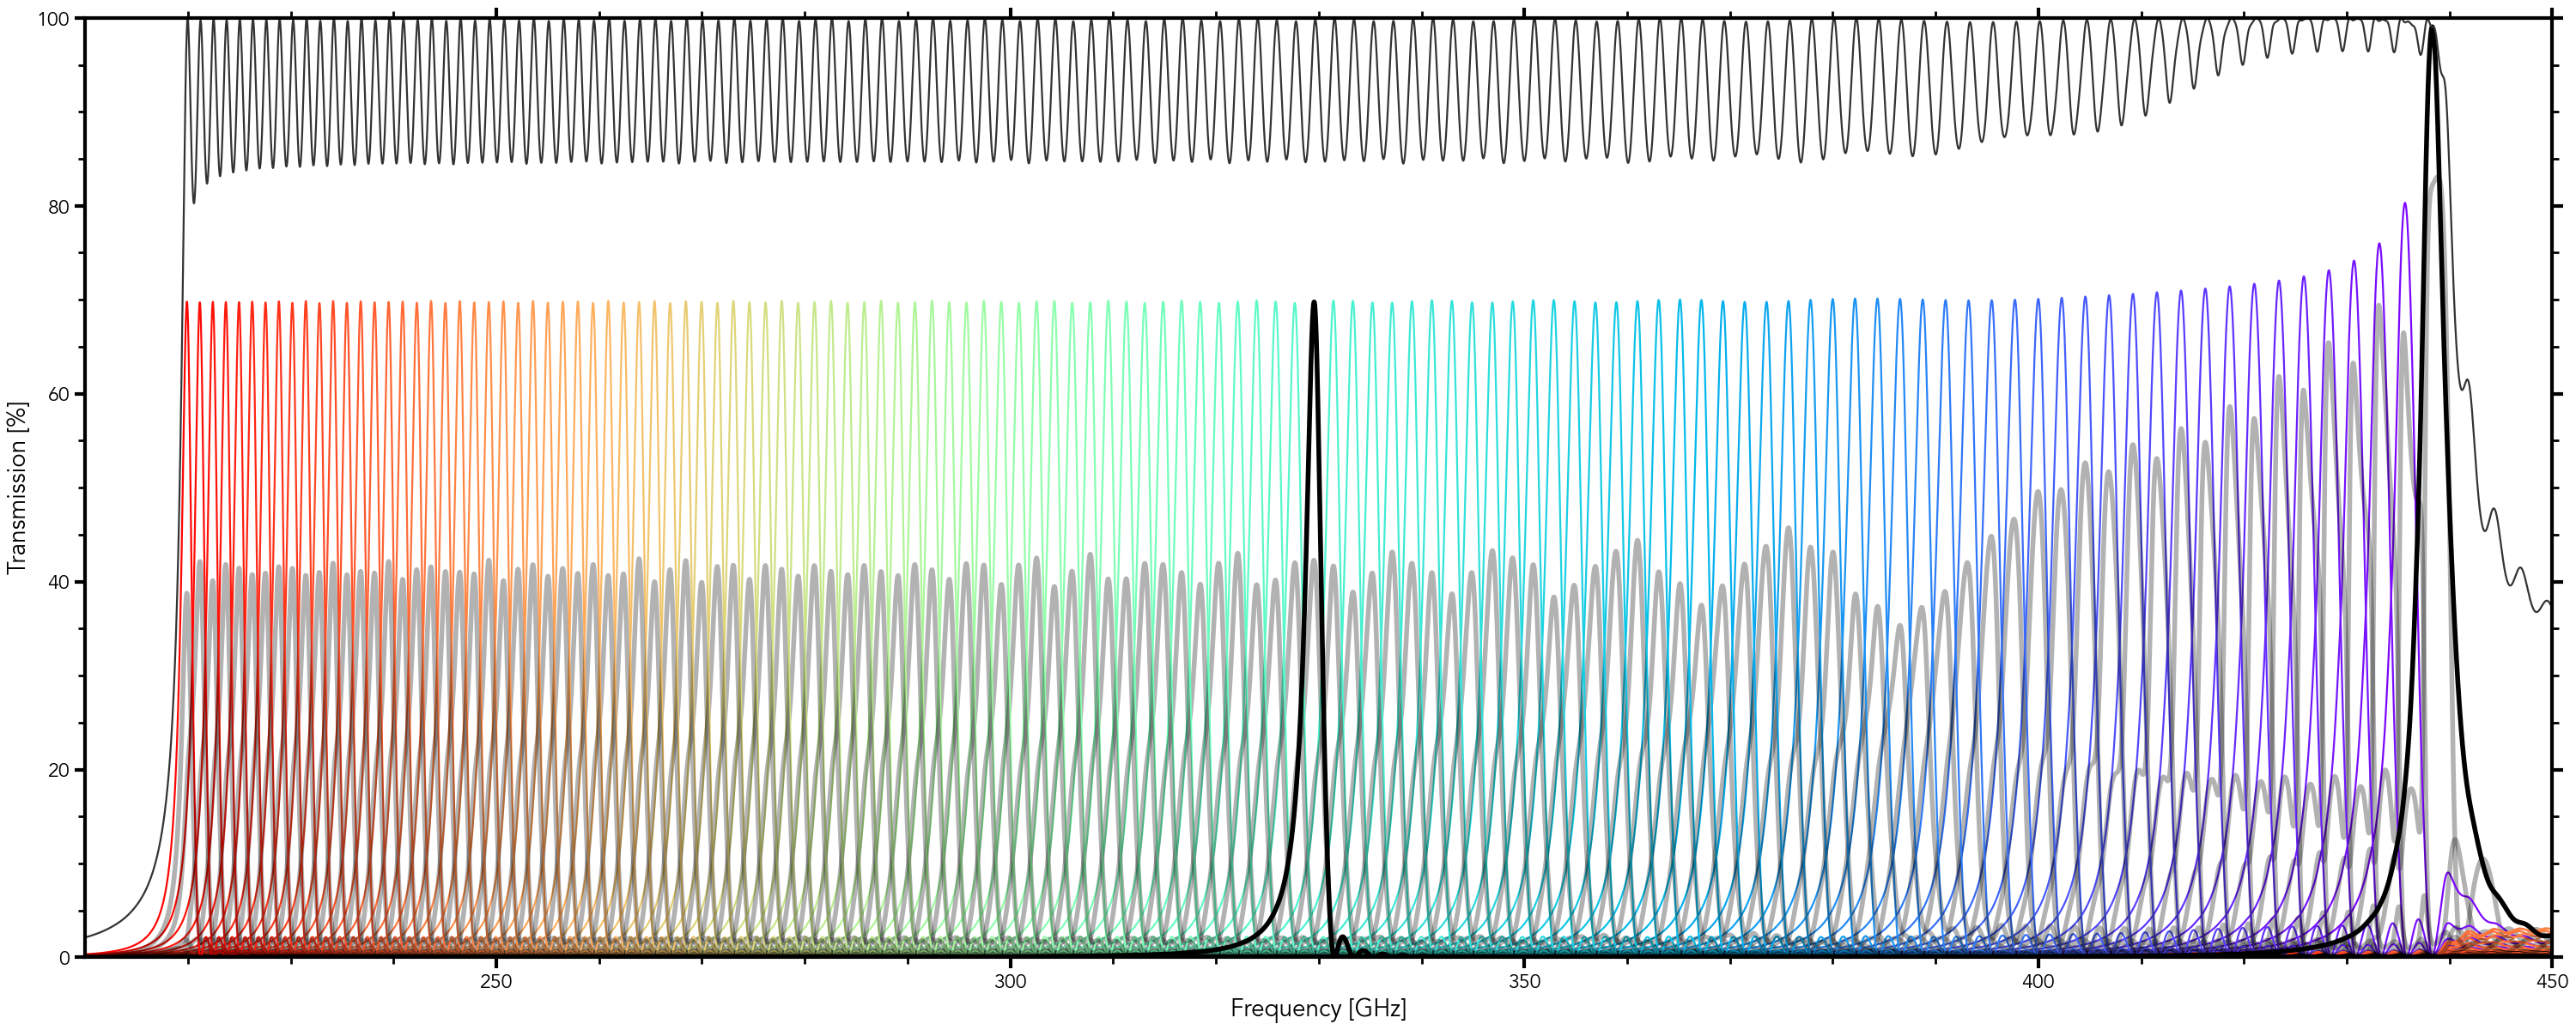

In [5]:
################################################
fig, ax =plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(15,6),layout='constrained')
plt.rcParams['lines.linewidth'] = 0.8


FB : Filterbank = R_sweep_data[DirectionalFilter][(500,500)]
S31_all = FB.S31_absSq_list

FB_Mani : Filterbank = R_sweep_data[ManifoldFilter][(500,500)]
S31_all_Mani = FB_Mani.S31_absSq_list

#ax
cmap = cm.get_cmap('rainbow').copy()
norm = mpl.colors.Normalize(vmin=0, vmax=np.shape(S31_all)[0])

for i,S31_absSq in enumerate(S31_all):
    
    ax.plot(f/1e9,100*S31_absSq,color=cmap(norm(i)))
    
    ax.plot(f/1e9,100*S31_all_Mani[i],color="0.0",alpha=0.3,linewidth=2)

for i,S31_absSq in enumerate(S31_all):
    if i in (0,50,125,210,310):
        ax.plot(f/1e9,100*S31_absSq,color="0.0",linewidth=2)    

sum_filters = np.sum(S31_all,axis=0)
ax.plot(f/1e9,100*sum_filters,label='sum filters',color="0.2")

envelope = np.array(FB.S31_absSq_list).max(axis=0)
# ax.plot(f/1e9,100*envelope["DirectionalFilter"],label='envelope',color=(0.,0.,0.))

# ax.plot(f/1e9,100*FB.S11_absSq,label='S11',color=(0.,1.,1.))
# ax.plot(f/1e9,100*FB.S21_absSq,label='S21',color=(1.,0.,1.))
# ax.vlines(Filterbank_data[(R_spacing,R_filter_width)].f0_realized[split_point[(R_spacing,R_filter_width)]]/1e9,100,0)

ax.set_ylim(0,100)
ax.set_xlim(210,450)
ax.set_xlabel('Frequency [GHz]');
ax.set_ylabel('Transmission [%]');  # Add a y-label to the axes.
# plt.title("Realized Q-factors")  # Add a title to the axes.
# ax.legend();  # Add a legend.

savestr = fig_path + "Filterbank_directional_filter_with_manifold_overlay.png"
## Transparent background but not in axis
fig.patch.set_facecolor('none')

# plt.savefig(fname=savestr,facecolor=fig.get_facecolor(),edgecolor='none')
fig.canvas.manager.set_window_title(savestr)



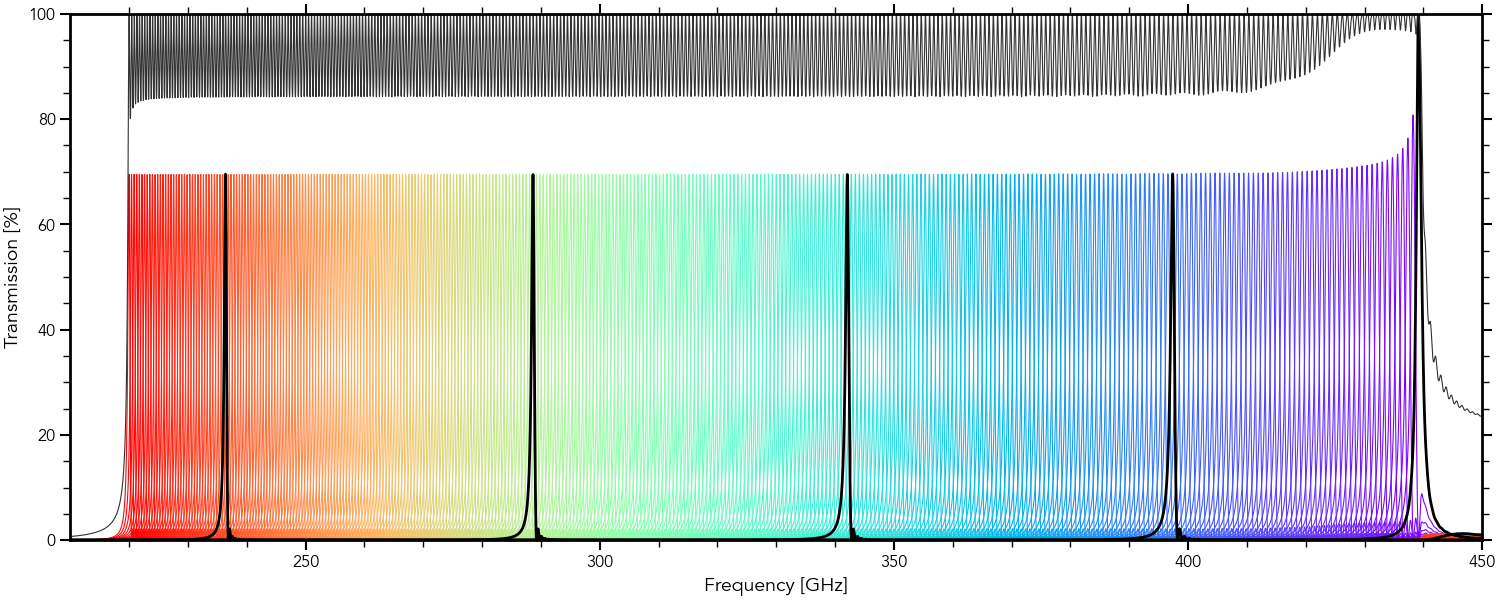

In [ ]:
################################################
fig, ax =plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(15,6),layout='constrained')



FB : Filterbank = R_sweep_data[DirectionalFilter][(500,500)]
S31_all = FB.S31_absSq_list

FB_Mani : Filterbank = R_sweep_data[ManifoldFilter][(500,500)]
S31_all_Mani = FB_Mani.S31_absSq_list

#ax
cmap = cm.get_cmap('rainbow').copy()
norm = mpl.colors.Normalize(vmin=0, vmax=np.shape(S31_all)[0])

for i,S31_absSq in enumerate(S31_all):
    
    ax.plot(f/1e9,100*S31_absSq,color=cmap(norm(i)))
    
    # ax.plot(f/1e9,100*S31_all_Mani[i],color="0.0",alpha=0.3,linewidth=2)

for i,S31_absSq in enumerate(S31_all):
    if i in (0,50,125,210,310):
        ax.plot(f/1e9,100*S31_absSq,color="0.0",linewidth=2)    

sum_filters = np.sum(S31_all,axis=0)
ax.plot(f/1e9,100*sum_filters,label='sum filters',color="0.2")

envelope = np.array(FB.S31_absSq_list).max(axis=0)
# ax.plot(f/1e9,100*envelope["DirectionalFilter"],label='envelope',color=(0.,0.,0.))

# ax.plot(f/1e9,100*FB.S11_absSq,label='S11',color=(0.,1.,1.))
# ax.plot(f/1e9,100*FB.S21_absSq,label='S21',color=(1.,0.,1.))
# ax.vlines(Filterbank_data[(R_spacing,R_filter_width)].f0_realized[split_point[(R_spacing,R_filter_width)]]/1e9,100,0)

ax.set_ylim(0,100)
ax.set_xlim(210,450)
ax.set_xlabel('Frequency [GHz]');
ax.set_ylabel('Transmission [%]');  # Add a y-label to the axes.
# plt.title("Realized Q-factors")  # Add a title to the axes.
# ax.legend();  # Add a legend.

savestr = fig_path + "Filterbank_directional_filter.png"
## Transparent background but not in axis
fig.patch.set_facecolor('none')

# plt.savefig(fname=savestr,facecolor=fig.get_facecolor(),edgecolor='none')
fig.canvas.manager.set_window_title(savestr)



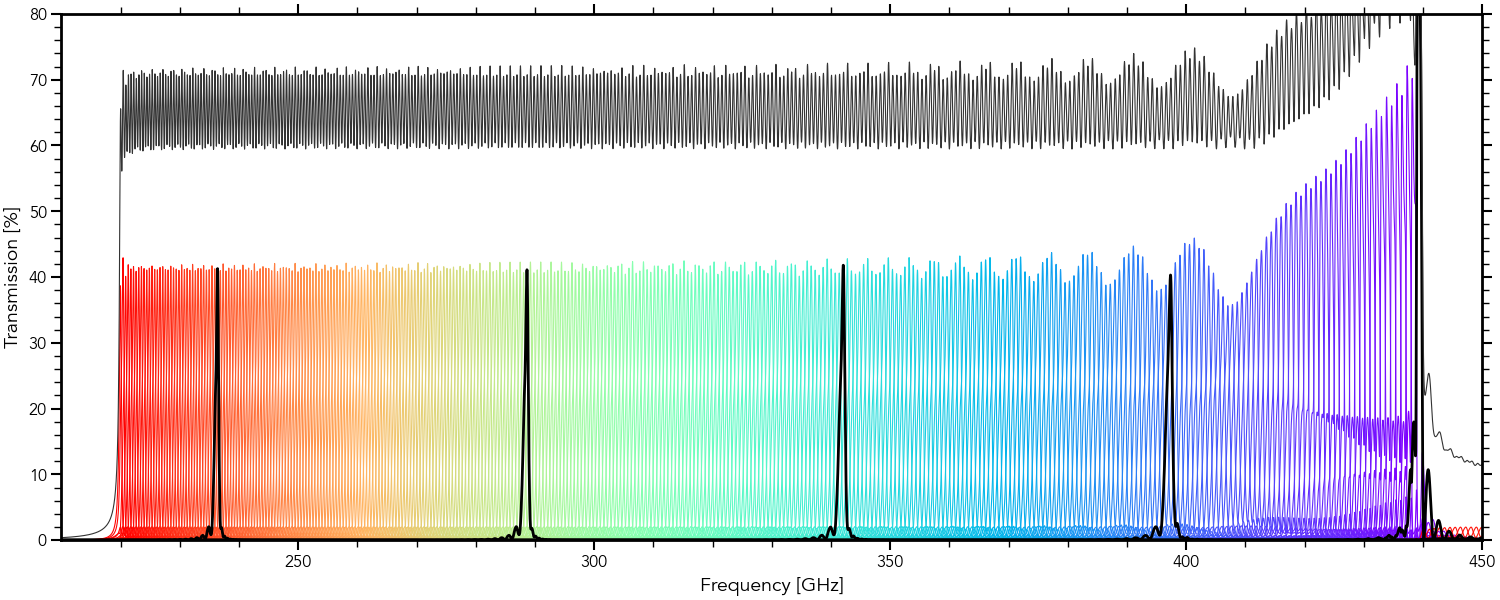

In [ ]:
################################################
fig, ax =plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(15,6),layout='constrained')



FB : Filterbank = R_sweep_data[ManifoldFilter][(500,500)]
S31_all = FB.S31_absSq_list

#ax
cmap = cm.get_cmap('rainbow').copy()
norm = mpl.colors.Normalize(vmin=0, vmax=np.shape(S31_all)[0])

for i,S31_absSq in enumerate(S31_all):
    
    ax.plot(f/1e9,100*S31_absSq,color=cmap(norm(i)))


for i,S31_absSq in enumerate(S31_all):
    if i in (0,50,125,210,310):
        ax.plot(f/1e9,100*S31_absSq,color="0.0",linewidth=2)    

sum_filters = np.sum(S31_all,axis=0)
ax.plot(f/1e9,100*sum_filters,label='sum filters',color="0.2")

envelope = np.array(FB.S31_absSq_list).max(axis=0)
# ax.plot(f/1e9,100*envelope["DirectionalFilter"],label='envelope',color=(0.,0.,0.))

# ax.plot(f/1e9,100*FB.S11_absSq,label='S11',color=(0.,1.,1.))
# ax.plot(f/1e9,100*FB.S21_absSq,label='S21',color=(1.,0.,1.))
# ax.vlines(Filterbank_data[(R_spacing,R_filter_width)].f0_realized[split_point[(R_spacing,R_filter_width)]]/1e9,100,0)

ax.set_ylim(0,80)
ax.set_xlim(210,450)
ax.set_xlabel('Frequency [GHz]');
ax.set_ylabel('Transmission [%]');  # Add a y-label to the axes.
# plt.title("Realized Q-factors")  # Add a title to the axes.
# ax.legend();  # Add a legend.

savestr = fig_path + "Filterbank_manifold_filter.png"
## Transparent background but not in axis
fig.patch.set_facecolor('none')

# plt.savefig(fname=savestr,facecolor=fig.get_facecolor(),edgecolor='none')
fig.canvas.manager.set_window_title(savestr)



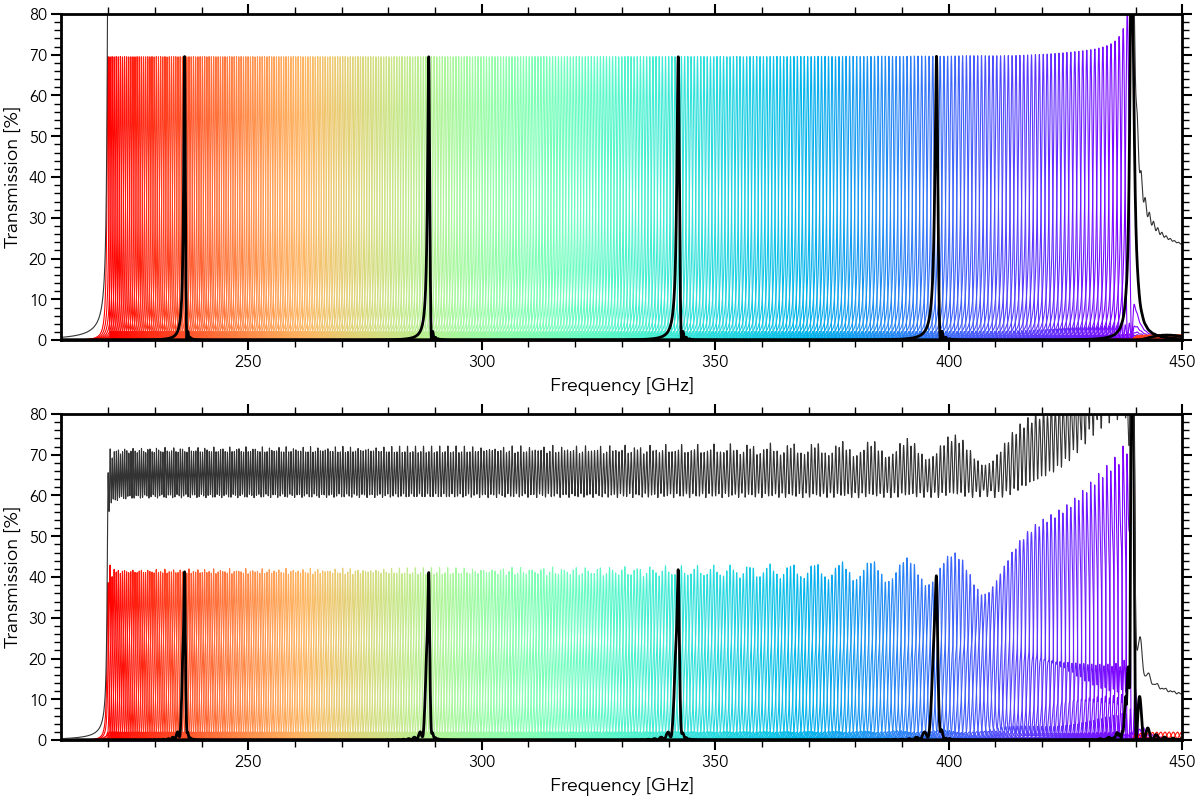

In [ ]:
################################################
fig, axs =plt.subplots(nrows=2,ncols=1,figsize=(12,8),layout='constrained')


for type_i,ax in enumerate(axs):
    filter_type = Filters[1-type_i]

    FB : Filterbank = R_sweep_data[filter_type][(500,500)]
    S31_all = FB.S31_absSq_list

    #ax
    cmap = cm.get_cmap('rainbow').copy()
    norm = mpl.colors.Normalize(vmin=0, vmax=np.shape(S31_all)[0])

    for i,S31_absSq in enumerate(S31_all):
        
        ax.plot(f/1e9,100*S31_absSq,color=cmap(norm(i)))


    for i,S31_absSq in enumerate(S31_all):
        if i in (0,50,125,210,310):
            ax.plot(f/1e9,100*S31_absSq,color="0.0",linewidth=2)    

    sum_filters = np.sum(S31_all,axis=0)
    ax.plot(f/1e9,100*sum_filters,label='sum filters',color="0.2")

    envelope = np.array(FB.S31_absSq_list).max(axis=0)
    # ax.plot(f/1e9,100*envelope["DirectionalFilter"],label='envelope',color=(0.,0.,0.))

    # ax.plot(f/1e9,100*FB.S11_absSq,label='S11',color=(0.,1.,1.))
    # ax.plot(f/1e9,100*FB.S21_absSq,label='S21',color=(1.,0.,1.))
    # ax.vlines(Filterbank_data[(R_spacing,R_filter_width)].f0_realized[split_point[(R_spacing,R_filter_width)]]/1e9,100,0)

    ax.set_ylim(0,80)
    ax.set_xlim(210,450)
    ax.set_xlabel('Frequency [GHz]');
    ax.set_ylabel('Transmission [%]');  # Add a y-label to the axes.
    # plt.title("Realized Q-factors")  # Add a title to the axes.
    # ax.legend();  # Add a legend.


savestr = fig_path + "Filterbank_both_with_variances.png"
## Transparent background but not in axis
fig.patch.set_facecolor('none')

# plt.savefig(fname=savestr,facecolor=fig.get_facecolor(),edgecolor='none')
fig.canvas.manager.set_window_title(savestr)



In [ ]:
# print(Filterbank_data[(R_spacing,R_filter_width)].Filters[split_point[(R_spacing,R_filter_width)]].sep)
# print(Filterbank_data[(R_spacing,R_filter_width)].Filters[split_point[(R_spacing,R_filter_width)]+1].sep)


In [ ]:
plt.close('all')

TypeError: 'AxesSubplot' object is not iterable

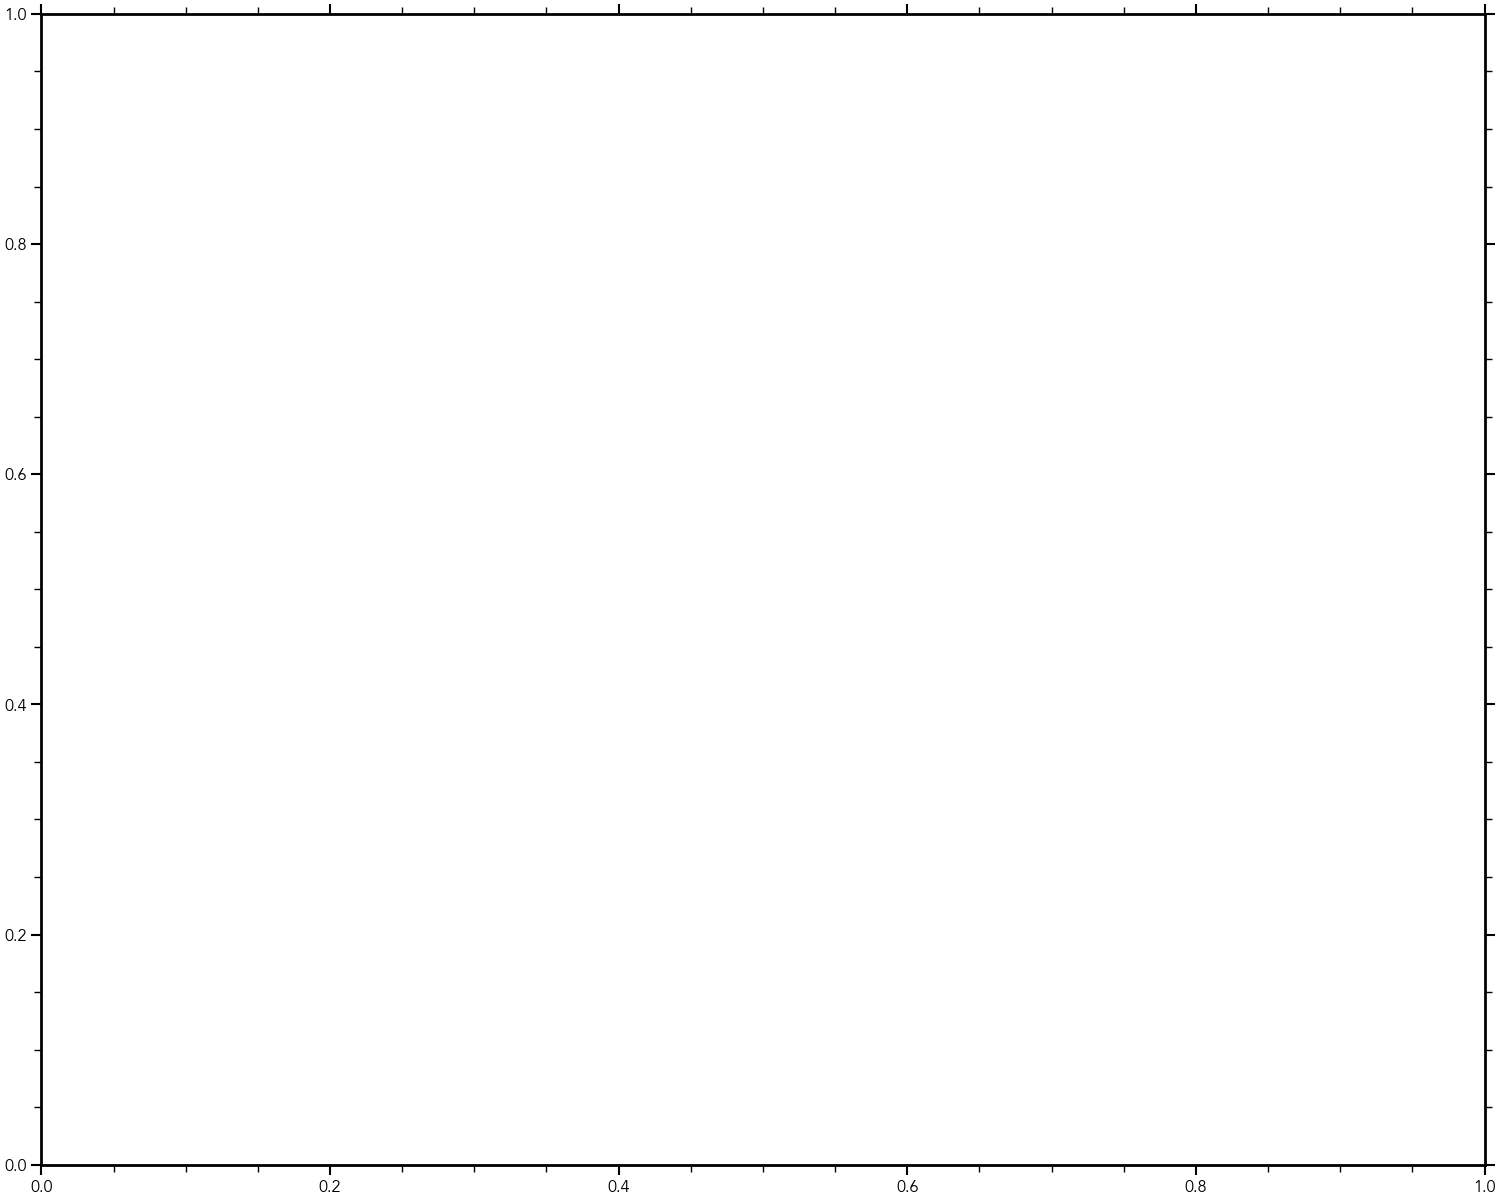

In [ ]:
fig, axs = plt.subplots(nrows=n_R_spacings,ncols=n_R_filter_widths,sharex=True,sharey=True,figsize=(15,12),layout='constrained')

for row, ax_row in enumerate(axs):
    for col, ax in enumerate(ax_row):
        
        for Filter in Filters:
            filt_name = str(Filter.__name__)
            FB : Filterbank = R_sweep_data[Filter][(R_spacings[row],R_filter_widths[col])]
            ax.scatter(FB.f0_realized/1e9,FB.Ql_realized,label=f"{filt_name} ({np.mean(FB.Ql_realized):.1f})",color=Filtertype_color_dict[filt_name])
            ax.hlines(np.mean(FB.Ql_realized),FB.f0_min/1e9,FB.f0_max/1e9,color=Filtertype_color_dict[filt_name])
            ax.set_title(f"({R_spacings[row]}, {R_filter_widths[col]})")
            ax.legend(loc='upper left')


fig.supxlabel("freq. [GHz]");
fig.supylabel("Q-factor");
fig.suptitle("Ql realized (R spacing, R filter)");

TypeError: 'AxesSubplot' object is not iterable

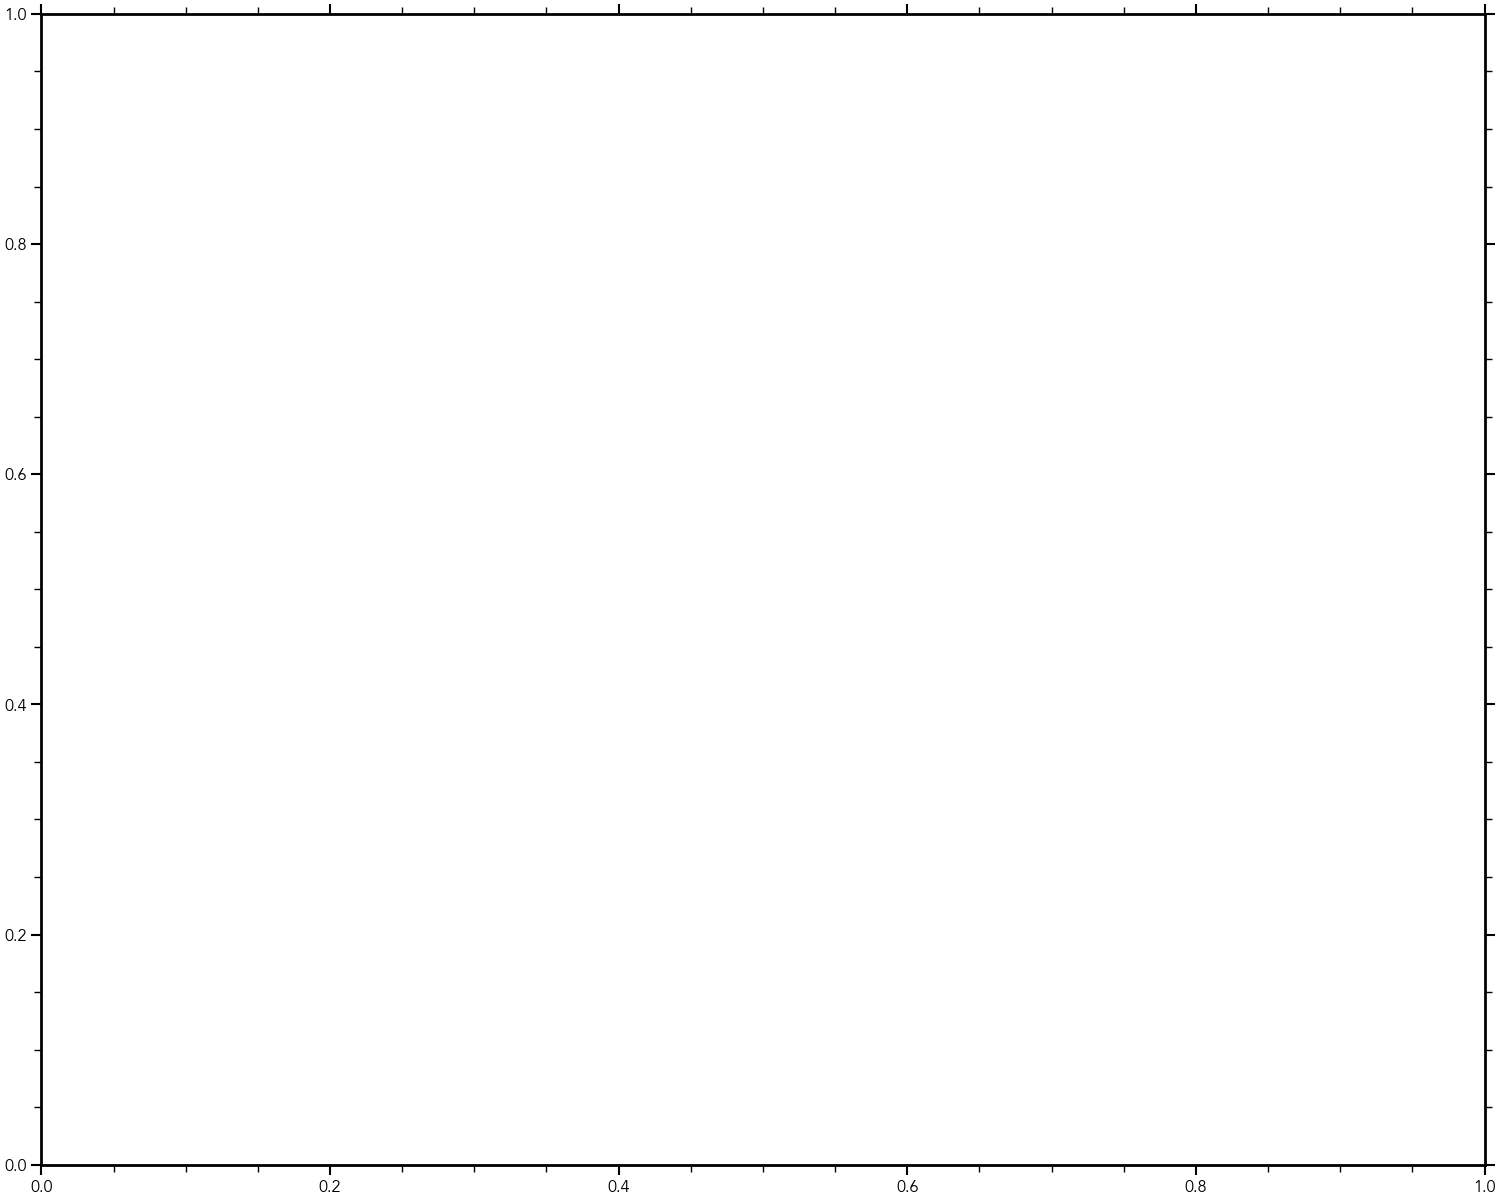

In [ ]:
fig, axs = plt.subplots(nrows=n_R_spacings,ncols=n_R_filter_widths,sharex=True,sharey=True,figsize=(15,12),layout='constrained')

for row, ax_row in enumerate(axs):
    for col, ax in enumerate(ax_row):
        
        for Filter in Filters:
            filt_name = str(Filter.__name__)
            FB : Filterbank = R_sweep_data[Filter][(R_spacings[row],R_filter_widths[col])]
            ax.scatter(FB.f0_realized/1e9,FB.inband_filter_eff,label=f"{filt_name} ({np.mean(FB.inband_filter_eff):.3f})",color=Filtertype_color_dict[filt_name])
            ax.hlines(np.mean(FB.inband_filter_eff),FB.f0_min/1e9,FB.f0_max/1e9,color=Filtertype_color_dict[filt_name])
            ax.set_title(f"({R_spacings[row]}, {R_filter_widths[col]})")
            ax.legend(loc='upper left')


fig.supxlabel("freq. [GHz]");
fig.supylabel("Efficiency");
fig.suptitle("In-band filter efficiency (R spacing, R filter)");